In [1]:
from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector, MaxPooling2D
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model, Sequential
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

from IPython.display import clear_output
import pandas as pd
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from os import makedirs, listdir
from time import time
from random import shuffle, randint

from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255. * 2 - 1###################
x_test  = x_test .astype('float32') / 255. * 2 - 1###################
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y = y_train

y_train = to_categorical(y_train).astype(np.float32)
y_test  = to_categorical(y_test).astype(np.float32)
clear_output()

dropout_rate = 0.25
num_class = 10
latent_dim = 8
batch_size = 256#128


lr_opt = 1e-3
lr_dopt = 1e-4

In [5]:
def add_units_to_conv2d(conv2, units):
        dim1 = int(conv2.shape[1])
        dim2 = int(conv2.shape[2])
        dimc = int(units.shape[1])
        repeat_n = dim1 * dim2
        units_repeat = RepeatVector(repeat_n)(units)
        units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
        return concatenate([conv2, units_repeat])

In [6]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [4]:
noise = Input(shape=(latent_dim,))
lbl_g = Input(shape=(num_class,))
x = concatenate([noise, lbl_g])
x = Dense(7 * 7 * 64, init="glorot_normal")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_rate)(x)
x = Reshape((7, 7, 64))(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(64, kernel_size=(5, 5), padding='same', init='glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_rate)(x)
x = Conv2D(32, kernel_size=(3, 3), padding='same', init='glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_rate)(x)
x = UpSampling2D(size=(2, 2))(x)
generated = Conv2D(1, kernel_size=(5, 5), activation='tanh', padding='same', init='glorot_uniform')(x)#sigmoid
gan_gen = Model([noise, lbl_g], generated, name='generator')

    
img = Input(shape=(28, 28, 1))
lbl = Input(shape=(num_class, ))
x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same', init='glorot_uniform', use_bias=False)(img)
x = add_units_to_conv2d(x, lbl)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(128, kernel_size=(3, 3), padding='same', init='glorot_uniform', use_bias=False)(x)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
x = LeakyReLU()(x)
out = Dense(1, activation='sigmoid', init="glorot_normal")(x)
gan_ds = Model([img, lbl], out, name='Discriminator')

    
make_trainable(gan_ds, False) #discrim.trainable = False
gan = Model([noise, lbl_g, lbl], gan_ds([gan_gen([noise, lbl_g]), lbl]))


clear_output()
gan_gen.summary()
gan_ds.summary()
gan.summary()

opt = Adam(lr=lr_opt)
gopt = Adam(lr=1e-4)
dopt = Adam(lr=lr_dopt)

gan_gen.compile(loss=binary_crossentropy, optimizer=gopt, metrics=['accuracy'])
gan.compile(loss=binary_crossentropy, optimizer=opt, metrics=[ 'accuracy'])

make_trainable(gan_ds, True)
gan_ds.compile(loss=binary_crossentropy, optimizer=dopt, metrics=['accuracy'])
gan_ds.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 18)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3136)         59584       concatenate_1[0][0]              
__________

In [5]:
def save_images(images):
    imstart = images[0].reshape((28, 28))
    for im in images[1:]:
        imstart = np.hstack((imstart, im.reshape((28,28))))
    imstart = np.vstack((imstart[:,28 * 32 * i:28 * 32 * (i + 1)] for i in range(batch_size // 32)))
    plt.imsave('./GAN/' + str(int(time() * 1000)) + '.jpg', imstart)

In [6]:
def train_mini_batch(x_data, y_data, batch_size):
    length = x_data.shape[0]
    inds = np.random.choice(np.arange(length), size=batch_size)
    return x_data[inds], y_data[inds]

In [7]:
def step_train_of_discriminator():
    true_image, label = train_mini_batch(x_train, y_train, batch_size)
    noise_gen = np.random.uniform(-1, 1, size=[batch_size, latent_dim])   # noise
    false_image = gan_gen.predict([noise_gen, label], batch_size=batch_size)  #False images
    x_train2 = np.vstack((true_image, false_image))#+ np.random.uniform(-0.5, 0.5, size=[batch_size * 2 ,28, 28, 1])#######
    label2train = np.vstack((label, label))
    y_tr2 = np.zeros([2 * batch_size, 1])
    y_tr2[:batch_size] = 1
    return gan_ds.train_on_batch([x_train2, label2train], y_tr2)

In [8]:
def step_train_of_ginerator():
    true_image, label = train_mini_batch(x_train, y_train, batch_size)
    noise_gen = np.random.uniform(-1, 1, size=[batch_size * 2, latent_dim])   # noise for train generator
    label2train = np.vstack((label, label))
    g_history = gan.train_on_batch([noise_gen, label2train, label2train], np.ones([batch_size*2, 1]))#train gan
    
    false_image = gan_gen.predict([noise_gen[:batch_size], label], batch_size=batch_size)  #False images
    save_images(false_image)
    x_train2 = np.vstack((true_image, false_image))
    label2train = np.vstack((label, label))
    y_tr2 = np.zeros([2*batch_size, 1])
    y_tr2[:batch_size] = 1
    
    return gan_ds.evaluate([x_train2, label2train], y_tr2, verbose=False)

In [ ]:
d_loss = []
d_accuracy = []
epochs=3000
d_history_loss = 1

for epoch in range(1, epochs):
    #if not epoch % 50:
            #save_weights
    gan_ds.save_weights('./GAN/gan_ds_weights_2.h5', True)
    gan_gen.save_weights('./GAN/gan_gen_weights_2.h5', True)
            # save loss
    df = pd.DataFrame( {'d_loss': d_loss, 'd_accuracy':d_accuracy} )
    df.to_csv('./GAN/gan_loss.csv', index=False)
        
        #lr_dopt *= 0.95
        #r_opt *= 0.95
        #gan_ds.optimizer.lr.assign(lr_dopt)
        #gan.optimizer.lr.assign(lr_opt)
        
    #if d_history_loss >= 0.69:
    while d_history_loss > 0.3:
        d_history_loss, d_history_accurcy =  step_train_of_discriminator()               #train discriminator
        d_loss.append(d_history_loss)
        d_accuracy.append(d_history_accurcy)
        print(d_history_loss,'a')
    
    #if d_history_loss <= 0.69:
    while d_history_loss < 1:
        d_history_loss, d_history_accurcy = step_train_of_ginerator()                    #train gineraror
        d_loss.append(d_history_loss)
        d_accuracy.append(d_history_accurcy)
        print(d_history_loss,'b')

    clear_output()

0.96986204 a
0.9580215 a
0.96889436 a
0.8616211 a
0.79696906 a
0.82523423 a
0.9126849 a
0.8618114 a
0.90288734 a
0.81931674 a
0.8101464 a
0.77299404 a
0.73562396 a
0.8393417 a
0.7257868 a
0.77491105 a
0.7393619 a
0.762871 a
0.6365144 a
0.71650517 a
0.6557437 a
0.66040385 a
0.63211894 a
0.65959907 a
0.6679139 a
0.6453874 a
0.61332786 a
0.61422145 a
0.5739266 a
0.57428813 a
0.5465132 a
0.6062772 a
0.5848285 a
0.5705124 a
0.61965054 a
0.5611175 a
0.55459523 a
0.5337855 a
0.55303526 a
0.5642094 a
0.5427156 a
0.5268923 a
0.51794386 a
0.5409145 a
0.53473437 a
0.52847254 a
0.5126304 a
0.5370984 a
0.532061 a
0.48484802 a
0.48007172 a
0.5053545 a
0.5020317 a
0.49232617 a
0.51031834 a
0.4820663 a
0.50277257 a
0.49515298 a
0.47923422 a
0.479628 a
0.4935478 a
0.469741 a
0.4557252 a
0.47730696 a
0.499596 a
0.5172932 a
0.47685087 a
0.47182825 a
0.5044687 a
0.4869374 a
0.49056184 a
0.48189074 a
0.44431347 a
0.46116805 a
0.47405827 a
0.46973884 a
0.4710022 a
0.44878095 a
0.44849354 a
0.46370193 a
0.42

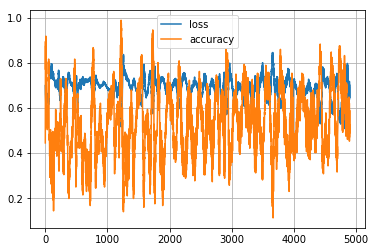

In [11]:
losses = pd.read_csv('./GAN/gan_loss.csv')
plt.plot(losses.d_loss, label="loss")
plt.plot(losses.d_accuracy, label='accuracy')
plt.legend()
plt.grid(True)

без 'if' с уменьшением  learning rate + sigmoid + x_train(0,1)

In [3]:
images = []
for filename in listdir('./GAN'):
    if filename.endswith('.jpg'):
        images.append(imageio.imread('./GAN/' + filename))
imageio.mimsave('./GAN/gifs/movie5.gif', images)

![img](./GAN/gifs/movie.gif)

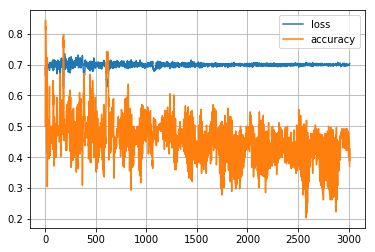

In [12]:
losses = pd.read_csv('./GAN/gan_loss.csv')
plt.plot(losses.d_loss, label="loss")
plt.plot(losses.d_accuracy, label='accuracy')
plt.legend()
plt.grid(True)

с 'if' (0.7)  с уменшением learning rate +   sigmoid + x_train(0,1)

![img](./GAN/gifs/movie1.gif)

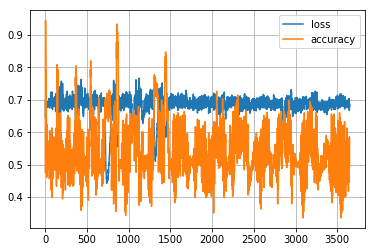

In [11]:
losses = pd.read_csv('./GAN/gan_loss.csv')
plt.plot(losses.d_loss, label="loss")
plt.plot(losses.d_accuracy, label='accuracy')
plt.legend()
plt.grid(True)

с 'if' (0.69)  без уменшением learning rate + sigmoid + x_train(0,1)

порог менше всего на 0,01 а модель утратила всю стабильность

![img](./GAN/gifs/movie2.gif)

Модель стала вовсе не обучаема, что говарит о весьма требовательной настройки ПСС

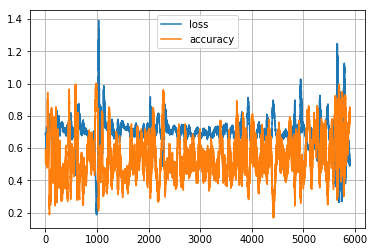

In [13]:
losses = pd.read_csv('./GAN/gan_loss.csv')
plt.plot(losses.d_loss, label="loss")
plt.plot(losses.d_accuracy, label='accuracy')
plt.legend()
plt.grid(True)

без 'if' (---)  без уменшением learning rate + tanh + x_train(-1, 1)

![img](./GAN/gifs/movie3.gif)

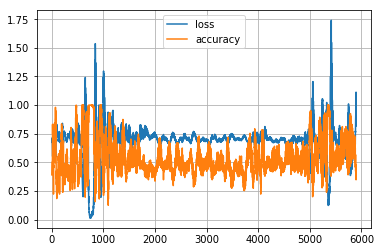

In [31]:
losses = pd.read_csv('./GAN/gan_loss.csv')
plt.plot(losses.d_loss, label="loss")
plt.plot(losses.d_accuracy, label='accuracy')
plt.legend()
plt.grid(True)

без 'if' (---)  без уменшением learning rate + tanh + x_train(-1, 1) + noise(-0.5, 0.5)

![img](./GAN/gifs/movie4.gif)

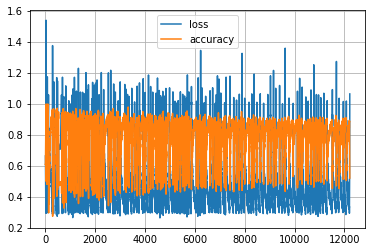

In [4]:
losses = pd.read_csv('./GAN/gan_loss.csv')
plt.plot(losses.d_loss, label="loss")
plt.plot(losses.d_accuracy, label='accuracy')
plt.legend()
plt.grid(True)

с 'while' (0,3 ; 1)  без уменшением learning rate + tanh + x_train(-1, 1)

![img](./GAN/gifs/movie5.gif)

[Click](https://habr.com/ru/post/416531/)

VAN + GAN
===

>GAN - Generative Adversarial Networks
VAE - variable auto encoder

![a](https://habrastorage.org/web/7a1/8db/d39/7a18dbd3969048c2b085cc707e539f0c.png)

In [2]:
from keras import backend

def sampling(args):
        z_mean, z_log_var = args
        epsilon = backend.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + backend.exp(z_log_var / 2) * epsilon

In [3]:
def vae_loss(x, decoded):
        x = backend.reshape(x, shape=(batch_size, 28*28))
        decoded = backend.reshape(decoded, shape=(batch_size, 28*28))
        xent_loss = 28*28*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * backend.sum(1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss) / 2 / 28 / 28

In [7]:
input_img = Input(shape=(28, 28, 1))
input_lbl = Input(shape=(num_class,), dtype='float32')
flatten_img = Flatten()(input_img)
x = concatenate([flatten_img, input_lbl])
x = Dense(512, init="glorot_normal")(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
encoded = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model([input_img, input_lbl], encoded, name="encoder")


noise = Input(shape=(latent_dim,))
lbl_g = Input(shape=(num_class,))
x = concatenate([noise, lbl_g])
x = Dense(7*7*64, init="glorot_normal")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_rate)(x)
x = Reshape((7, 7, 64))(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(64, kernel_size=(5, 5), padding='same', init='glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_rate)(x)
x = Conv2D(32, kernel_size=(3, 3), padding='same', init='glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_rate)(x)
x = UpSampling2D(size=(2, 2))(x)
generated = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same', init='glorot_uniform')(x)
generator = Model([noise, lbl_g], generated, name='generator')


img = Input(shape=(28, 28, 1))
lbl = Input(shape=(num_class,))
x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same', init='glorot_uniform')(img)
x = add_units_to_conv2d(x, lbl)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(128, kernel_size=(3, 3), padding='same', init='glorot_uniform')(x)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
x = Dense(28*28, init="glorot_normal")(x)
x = LeakyReLU()(x)
d = Dense(1, activation='sigmoid', init="glorot_normal")(x)
discrim = Model([img, lbl], d, name='Discriminator')


make_trainable(encoder, True)
AE = Model([input_img, input_lbl, lbl_g], generator([encoder([input_img, input_lbl]), lbl_g]))#trainable / trainable
make_trainable(discrim, False)
GAN = Model([noise, lbl_g, lbl], discrim([generator([noise, lbl_g]),lbl]))                    #trainable / Not trainable
make_trainable(encoder, False)
MODEL = Model([input_img, input_lbl, lbl_g, lbl],
    discrim([generator([encoder([input_img, input_lbl]), lbl_g]), lbl]))        #Not trainable / trainable / Not trainable

make_trainable(discrim, True)
make_trainable(encoder, True)
clear_output()

In [8]:
lrAE = 1e-5
lrDis = 4e-5

AE.compile(optimizer=Adam(lrAE), loss=vae_loss)                   # need for train encoder and decoder
generator.compile(optimizer=Adam(lrAE), loss=binary_crossentropy) # need for False images
discrim.compile(optimizer=Adam(lrDis), loss=binary_crossentropy)  # for train discriminator
MODEL.compile(optimizer=Adam(lrAE), loss=binary_crossentropy)     # need for train decoder

def step_to_train_encoder_and_decoder():
    x, y = train_mini_batch(x_train, y_train, batch_size)
    return AE.train_on_batch([x, y, y], x)

def step_train_of_discriminator2():
    true_image, label = train_mini_batch(x_train, y_train, batch_size)
    false_image = AE.predict([true_image, label, label], batch_size=batch_size)  #False images
    x_train2 = np.vstack((true_image, false_image))
    label2train = np.vstack((label, label))
    y_tr2 = np.zeros([2 * batch_size, 1])
    y_tr2[:batch_size] = 1
    return discrim.train_on_batch([x_train2, label2train], y_tr2)

def step_train_decoder():
    true_image, label = train_mini_batch(x_train, y_train, batch_size)
    g_history = MODEL.train_on_batch([true_image, label, label, label], np.ones([batch_size, 1]))#train gan
    false_image = AE.predict([true_image, label, label], batch_size=batch_size * 2)  #False images
    save_images(false_image)
    x_train2 = np.vstack((true_image, false_image))
    label2train = np.vstack((label, label))
    y_tr2 = np.zeros([2*batch_size, 1])
    y_tr2[:batch_size] = 1
    return discrim.evaluate([x_train2, label2train], y_tr2, verbose=False)

***

Перенос стиля VGG19
===

In [2]:
import keras
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from keras.applications import vgg19
from keras import backend as K

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```


Where `distance` is a norm function such as the L2 norm, `content` is a function that takes an image and computes a representation of its 
"content", and `style` is a function that takes an image and computes a representation of its "style".

Minimizing this loss would cause `style(generated_image)` to be close to `style(reference_image)`, while `content(generated_image)` would 
be close to `content(generated_image)`, thus achieving style transfer as we defined it.

A fundamental observation made by Gatys et al is that deep convolutional neural networks offer precisely a way to mathematically defined 
the `style` and `content` functions. Let's see how.

## The content loss


As you already know, activations from earlier layers in a network contain _local_ information about the image, while activations from 
higher layers contain increasingly _global_ and _abstract_ information. Formulated in a different way, the activations of the different 
layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore we expect the "content" of 
an image, which is more global and more abstract, to be captured by the representations of a top layer of a convnet.

A good candidate for a content loss would thus be to consider a pre-trained convnet, and define as our loss the L2 norm between the 
activations of a top layer computed over the target image and the activations of the same layer computed over the generated image. This 
would guarantee that, as seen from the top layer of the convnet, the generated image will "look similar" to the original target image. 
Assuming that what the top layers of a convnet see is really the "content" of their input images, then this does work as a way to preserve 
image content.

## The style loss


While the content loss only leverages a single higher-up layer, the style loss as defined in the Gatys et al. paper leverages multiple 
layers of a convnet: we aim at capturing the appearance of the style reference image at all spatial scales extracted by the convnet, not 
just any single scale.

For the style loss, the Gatys et al. paper leverages the "Gram matrix" of a layer's activations, i.e. the inner product between the feature maps 
of a given layer. This inner product can be understood as representing a map of the correlations between the features of a layer. These 
feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically corresponds to the appearance 
of the textures found at this scale.

Hence the style loss aims at preserving similar internal correlations within the activations of different layers, across the style 
reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales will look similar 
across the style reference image and the generated image.

In [3]:
# путь к картинке которую необходимо трансформировать.
target_image_path = './m.jpg'
# путь к картинке несущую стиль.
style_reference_image_path = './gog.jpg'

# размеры картники.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [4]:
# преобразует картинку в удобный формат для vgg19
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # удаляет центрирование и делает обратное действие функции выше
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
target_image = K.constant(preprocess_image(target_image_path))                  #картинка содержания
style_reference_image = K.constant(preprocess_image(style_reference_image_path))#картинка стиля

# placeholder для гинерируемой картинки
combination_image = K.placeholder((1, img_height, img_width, 3))

# оеденяем все во едино, образуя входной тензор
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# загружаем модель
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

W0911 15:34:05.417950  8280 deprecation_wrapper.py:119] From C:\Users\Bogdan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0911 15:34:05.424959  8280 deprecation_wrapper.py:119] From C:\Users\Bogdan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0911 15:34:05.427945  8280 deprecation_wrapper.py:119] From C:\Users\Bogdan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0911 15:34:05.459088  8280 deprecation_wrapper.py:119] From C:\Users\Bogdan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0911 15:34:05.846478  8280 deprecation_wrapper.py:119] From C:\Users\Bogda

Model loaded.


In [6]:
def content_loss(base, combination):          #ошибка контента
    return K.sum(K.square(combination - base))

In [7]:
def gram_matrix(x):             #матрица грэмма
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):#ошибка стиля
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [8]:
def total_variation_loss(x):#полная ошибка, стимуоирующая пространственную целостность
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [9]:
# словарь с всеми слоями сети vgg19
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# слой для подсчета ошибки содержания
content_layer = 'block5_conv2'
# слой для подсчета ошибки стиля
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# настройки влияния
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# определяем все потери
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

W0911 15:34:08.973294  8280 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [10]:
# с помощью градиентного спуска находим точку(картинку) в которой ошибка будет минимальной
grads = K.gradients(loss, combination_image)[0]

# функция для нахождения текущего градиента и ошибки
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

W0911 15:34:11.110683  8280 deprecation.py:323] From C:\Users\Bogdan\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
result_prefix = 'style_transfer_result'
iterations = 20


x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2050614500.0


C:\Users\Bogdan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 157s
Start of iteration 1
Current loss value: 1177891700.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 156s
Start of iteration 2
Current loss value: 881647600.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 157s
Start of iteration 3
Current loss value: 734236350.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 156s
Start of iteration 4
Current loss value: 628704450.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 156s
Start of iteration 5
Current loss value: 538459800.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 156s
Start of iteration 6
Current loss value: 472653380.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 157s
Start of iteration 7
Current loss value: 424412930.0
Image saved as style_trans

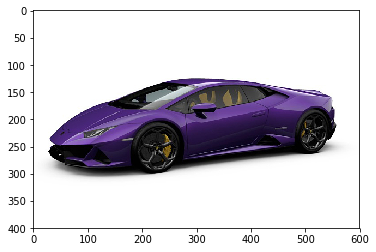

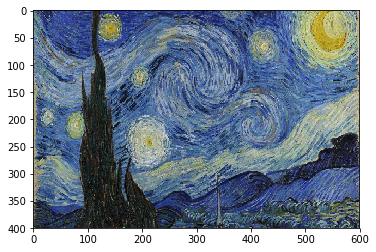

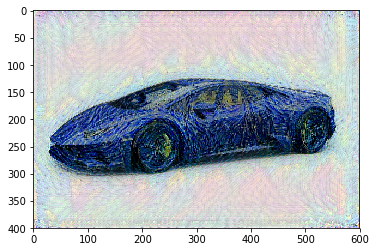

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

# контент картнка
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# стиль картнка
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# новая картника
plt.imshow(img)
plt.show()